## **1**. Imports

In [1]:
ON_COLAB=False
if ON_COLAB:
    from google.colab import drive
    drive.mount('/content/drive',force_remount=True)
    BASEDIR='/content/drive/My Drive/MentalHealthShared/'
    PYTHONDIR=BASEDIR+'src'
    RESULTSDIR=BASEDIR+'results/'
    MODELSDIR=BASEDIR+'model/'
    DATADIR=BASEDIR+'data/'
    import models
    import pytorchtools
    from utils import reset_seeds, count_parameters, evaluate, train_over_nepochs, createTensorDataset
    from training_functions import load_df, compute_bin_weights, save_stats_tensors, load_stats_tensors, get_znorm_params, get_subreddit_range, split_indices, get_subreddit_weights, get_baselines_df, WeightedL1Loss, WeightedMSELoss, grid_search_train
else:
    import os
    BASEDIR = os.getcwd() + "/"
    dirs = ["results","model","data"]
    for dirc in dirs:
        if dirc not in os.listdir(): 
            os.makedirs(os.path.join(BASEDIR,dirc))
    PYTHONDIR=BASEDIR+'src/'
    RESULTSDIR=BASEDIR+'results/'
    MODELSDIR=BASEDIR+'model/'
    DATADIR=BASEDIR+'data/'
    from src import models
    from src import pytorchtools
    from src.utils import reset_seeds, count_parameters, evaluate, train_over_nepochs, createTensorDataset
    from src.training_functions import load_df, compute_bin_weights, save_stats_tensors, load_stats_tensors, get_znorm_params, get_subreddit_range, split_indices, get_subreddit_weights, get_baselines_df, WeightedL1Loss, WeightedMSELoss, grid_search_train

In [2]:
# DEFINE SUBREDDITS
SUBREDDITS  = ['Anxiety','bipolar','depression','SuicideWatch'] 

subreddit2title = {'depression':'DEP','suicidewatch':'SUI','anxiety':'ANX','bipolar':'BIP'}

EXTENSION = '.parquet'
STRATIFIED = True  # If true, will apply a stratified K-fold cross-validation to the dataset.
TRAIN = True # If true, will train the models

USE_GRU = True # If true, will use the GRU RNN model in training
USE_XGB = False # If true, will use the XGBoost model in training

GRID_SEARCH_XGB = False # If true, will do a grid search for the XGBoost model
PLOT_XGB = False # If true, will plot the results found by the XGBoost model(Only available if TRAIN = True)

TEST  = False # If true, will test the models

ZNORMALIZE = False # If true, will apply a z-normalization to the dataset


KEEP_TEXT = True # Only True if using Section 6 for Case Study


assert TRAIN ^ TEST # either TRAIN or TEST

FILTERED=True # If true will use filtered seq_len for the threads
BIN_WIDTH=0.2 # Controls the width of the bins used to calculate the weighted L1 loss
MIN_VALUE = -1 # Controls the minimum output value(set to -1)


INCLUDE_TARGET = 0
INCLUDE_THREAD_COMMENTS = 0


MAX_BRANCH_LEN = 16   # not including authors' last comment
MAX_THREAD_LEN = 64   # not including authors' last comment

In [3]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device == torch.device('cuda'):
    print(f"Device successfully set to cuda")
else:
    print("WARNING! DEVICE IS NOT SET TO CUDA")

print(torch.__version__)

WARNING! DEVICE IS NOT SET TO CUDA
1.8.1


In [4]:
import sys
sys.path.append(PYTHONDIR)
import random
import pickle
import time
import pdb
import importlib
import itertools
import pprint
import copy
import os

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV,train_test_split
from sklearn.metrics import mean_squared_error

from tqdm.notebook import tqdm
from scipy import stats

import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset, DataLoader, random_split, Sampler, SubsetRandomSampler, Subset

from xgboost import XGBRegressor, Booster, DMatrix


# **2**. Creating a RedditDataset or TensorDataset instance

Instead of using a custom Dataset class (former ```RedditDataset```), we store the data required by the experiments in a ```TensorDataset``` to speed up the retrieval of the batchs.

```set_threads``` is a list of indexes containing the threads to be used as a dataset.

## **2.1** Build the source data

* Build the source data in order to predict the EmT based on the sequence of comments in a thread

In [5]:
suffix='_distilbert_filtered_posts' + EXTENSION
df_list = {subreddit:load_df(DATADIR+subreddit+suffix, MAX_THREAD_LEN) \
           for subreddit in SUBREDDITS}

post_df = pd.concat((df_list[subreddit] for subreddit in SUBREDDITS), keys=SUBREDDITS)
del df_list

Loading C:\Users\fabri\SentiMentalHealth/data/bipolar_distilbert_filtered_posts.parquet...


In [7]:
# TODO: it seems that we are keeping everything if KEEP_TEXT. is this really necessary?
if not KEEP_TEXT:
  post_df = post_df[['created_utc', 'seq_len','score', 'features', 'filtered_seqlen','valid_branches','comments']]

# new strategy to construct observations: follow branches of every discussion tree 
#post_df.drop(columns=['valid_branches'],inplace=True)

if FILTERED:
    # dropna on filtered_seqlen, then replace seq_len by filtered_seqlen
    post_df.dropna(subset=['filtered_seqlen'], inplace=True)
    post_df.filtered_seqlen = post_df.filtered_seqlen.astype(int)

    post_df.drop(columns='seq_len',inplace=True)
    post_df.rename(columns={'filtered_seqlen':'seq_len'},inplace=True)
else:
    post_df.drop(columns='filtered_seqlen',inplace=True)

print(f'Fraction of threads that had to be truncated: {(post_df.seq_len>(MAX_THREAD_LEN+1)).mean()}')


Fraction of threads that had to be truncated: 0.002204531537048377


In [ ]:
# TODO: define constants upfront
if ZNORMALIZE:
  prefix = ''
else:
  prefix = 'unnorm_'

# TODO: place z-normalization in a new function and explain what it does

if TRAIN:
  if ZNORMALIZE:
    src_m, src_s = get_znorm_params(post_df)
  else:
    shape = [1,post_df.iloc[0].features.shape[-1]]
    src_m = torch.zeros(shape)
    src_s = torch.ones(shape)

  save_stats_tensors(src_m,src_s,f'{BASEDIR}data/{prefix}')
  
if TEST:
  src_m, src_s = load_stats_tensors(f'{BASEDIR}data/{prefix}')

score_m = float(src_m[0,-2])
score_s = float(src_s[0,-2])

print(f'Average score in dataset is {score_m}')

subreddit2range = get_subreddit_range(post_df)
print(subreddit2range[SUBREDDITS[0]])

# TODO: define constants upfront
suffix = "random"
if STRATIFIED:
  suffix += '_strat'

# TODO: place indexing in a new function and explain what it does
# get indices
if TRAIN:
  if len(SUBREDDITS) == 4:
      train_inds, valid_inds, test_inds  = split_indices(post_df, STRATIFIED, MIN_VALUE, BIN_WIDTH)
  else:
    subreddit = SUBREDDITS[0]
    with open(f'{DATADIR}{subreddit}_{suffix}_splits.pkl','rb') as infile:
      splits = pickle.load(infile)
      train_locs =  [(subreddit,loc) for loc in splits[0]]
      valid_locs =  [(subreddit,loc) for loc in splits[1]]
      test_locs  =  [(subreddit,loc) for loc in splits[2]]

    train_inds = post_df.index.get_indexer_for(train_locs)
    valid_inds = post_df.index.get_indexer_for(valid_locs)
    test_inds  = post_df.index.get_indexer_for(test_locs)


if TEST:
  train_locs = []
  valid_locs = []
  test_locs  = []
  for subreddit in SUBREDDITS:
      with open(f'{DATADIR}{subreddit}_{suffix}_splits.pkl','rb') as infile:
        splits = pickle.load(infile)
        test_locs += [(subreddit,loc) for loc in splits[2]]

  # extract instances
  print(len(post_df))
  post_df = post_df.loc[test_locs]
  print(len(post_df))

# compute weights for Weighted L1 Loss
subreddit2weights = get_subreddit_weights(post_df, BIN_WIDTH,MIN_VALUE,device)
print(subreddit2weights)


In [ ]:
%%time

# TODO: place the dataset generation in a function


print('Creating src')

print('Creating y')
y = torch.Tensor(post_df.apply(lambda p: p.score[p.seq_len-1], axis=1).values)

print('Creating src_len_series')
src_len_series = post_df.seq_len-1
max_length=MAX_THREAD_LEN

if USE_GRU:
    src = nn.utils.rnn.pad_sequence(
    [ p.features[:min(MAX_THREAD_LEN,p.seq_len-1),:] for index, p in post_df.iterrows()], batch_first=True)
    # src = nn.utils.rnn.pad_sequence(
    # [ (p.features[:min(MAX_THREAD_LEN,p.seq_len-1),:]-src_m)/src_s for index, p in post_df.iterrows()], batch_first=True)
    print(f"GRU src tensor size: {src.size()}")

if USE_XGB:      
    src_xgb = torch.cat((
        torch.cat([torch.mean((p.features[:min(MAX_THREAD_LEN,p.seq_len-1),:]-src_m)/src_s,keepdims=True,dim=0) for index, p in post_df.iterrows()],axis=0),
        torch.cat([torch.max((p.features[:min(MAX_THREAD_LEN,p.seq_len-1),:]-src_m)/src_s,keepdims=True,dim=0)[0] for index, p in post_df.iterrows()],axis=0)
        ),1)
    print(f"XGB src tensor size: {src_xgb.size()}")


print(f'y tensor size: {y.size()}')


if INCLUDE_TARGET:
  tgt = nn.utils.rnn.pad_sequence(
    [(p.features[b[-2]]-src_m)/src_s for index, p in post_df.iterrows() for b in p.valid_branches],
  batch_first=True)
else:
  tgt = None

  # clean up memory
  #if (not TEST) and (not KEEP_TEXT):
  if (not KEEP_TEXT):
    del post_df

  print('Creating dataset')
  if USE_GRU:
    #dataset = createTensorDataset(src, src_len_series, y, tgt=tgt, max_length=max_length) # all threads, lim 63 comments
    dataset = createTensorDataset(src, src_len_series, y, max_length=max_length) # all threads, lim 63 comments
    del src
  if USE_XGB:
    dataset_xgb = createTensorDataset(src_xgb, src_len_series, y, max_length=max_length)
    del src_xgb
  
  del src_len_series, tgt, y

In [ ]:
# TODO: can we get EMBEDDING_DIM earlier, from post_df?

if USE_GRU:
  batch = dataset[0]
  EMBEDDING_DIM = batch[0].shape[-1]
  print(f"embedding dimension for GRU: {EMBEDDING_DIM}")
if USE_XGB:
  batch = dataset_xgb[0]
  EMBEDDING_DIM_XGB = batch[0].shape[-1]
  print(f"embedding dimension for XGB: {EMBEDDING_DIM_XGB}")

## **2.2** Create training, validation and test sets

In [ ]:
#%%time

print("Creating dataloaders...")
if TRAIN:
  if USE_XGB:
    train_loader_xgb = DataLoader(Subset(dataset_xgb,train_inds), batch_size=len(train_inds), shuffle=True, num_workers=0)
    valid_loader_xgb = DataLoader(Subset(dataset_xgb,valid_inds), batch_size=len(valid_inds), shuffle=False, num_workers=0)
    test_loader_xgb  = DataLoader(Subset(dataset_xgb, test_inds), batch_size=len(test_inds), shuffle=False, num_workers=1) 

  if USE_GRU: 
      train_loader = DataLoader(Subset(dataset,train_inds), batch_size=32, shuffle=True, num_workers=1)
      valid_loader = DataLoader(Subset(dataset,valid_inds), batch_size=len(valid_inds), shuffle=False, num_workers=1)
      test_loader  = DataLoader(Subset(dataset, test_inds), batch_size=len(test_inds), shuffle=False, num_workers=1)


if TEST:
  if USE_GRU:
   test_loader  = DataLoader(dataset, batch_size=len(dataset), shuffle=False, num_workers=1)
  if USE_XGB:
    test_loader_xgb  = DataLoader(dataset_xgb, batch_size=len(dataset_xgb), shuffle=False, num_workers=1)


# **3**. Training the models

## **3.1** (Stacked) (Bi-) GRU model

Takes one source sequence as input.

Example of how to run the model.

In [ ]:
# TODO: define the constants upfront; explain what this cell does
N_EPOCHS=20 # maximum number of epochs to train the model
PATIENCE=3 # constant that controls the Early Stopping mechanism of the grid search for the GRU model

# make sure it is a list
if type(SUBREDDITS) != list:
  SUBREDDITS = list(SUBREDDITS)

if TRAIN:
  if len(SUBREDDITS) == 4:
    SRC_DATASET='all'
  if len(SUBREDDITS) == 1:
    SRC_DATASET=SUBREDDITS[0]

if TEST:
  SRC_DATASET='all'
  #SRC_DATASET='whatisthisthing'  
  # SRC_DATASET=SUBREDDITS[0] # use model trained with own dataset

PREFIX ='random'
if STRATIFIED:
  PREFIX += '_strat'

results_filename=f'{RESULTSDIR}{PREFIX}_{SRC_DATASET}_b{int(2./BIN_WIDTH):02}_f{FILTERED}_n{N_EPOCHS}_p{PATIENCE}_mGRUv1.pkl'

#results_filename=f'{DATADIR}{PREFIX}_{SRC_DATASET}_b{int(2./BIN_WIDTH):02}_f{FILTERED}_n{N_EPOCHS}_p{PATIENCE}_mGRUv1.pkl'
print(f'Results file is {results_filename}')

In [ ]:
%%time
GRID_SEARCH = False
USE_PAPER_SETUP = True
assert GRID_SEARCH != USE_PAPER_SETUP

if TRAIN:

    # test_params
    if GRID_SEARCH:
        hidden_size_list     = [64]
        bidirectional_list   = [True]
        nlayers_dropout_list = [0.0]
    if USE_PAPER_SETUP:
        hidden_size_list     = [4, 16, 64]
        bidirectional_list   = [False, True]
        nlayers_dropout_list = [(1,0.)] + [(2,prob) for prob in [0., .1, .2, .5]]
        
    train_criteria=[WeightedL1Loss( subreddit2weights['all'],BIN_WIDTH, MIN_VALUE)]
    test_criteria =[WeightedL1Loss( subreddit2weights['all'],BIN_WIDTH, MIN_VALUE),
              WeightedMSELoss(subreddit2weights['all'],BIN_WIDTH, MIN_VALUE),
              nn.L1Loss(), nn.MSELoss()]

    results_df = grid_search_train(train_loader,valid_loader,hidden_size_list, bidirectional_list, nlayers_dropout_list, train_criteria, test_criteria, results_filename,EMBEDDING_DIM=EMBEDDING_DIM, PLOT=False,N_EPOCHS=N_EPOCHS,PATIENCE=PATIENCE)

In [ ]:
# show best results
print(f'Loading {results_filename}...')
results_df = pd.read_pickle(results_filename)

results_df_view = pd.concat((results_df,results_df['params'].apply(pd.Series)), axis=1).drop(
    columns=['params','dropout_out','input_size','output_size','uses_two_series_as_input','para','para_best'])

results_df_view.sort_values('WeightedL1Loss').head(10)

In [ ]:
# plot relationship between losses
results_df.plot.scatter('WeightedL1Loss_best', 'WeightedL1Loss')

### Duplicate functions

These functions have been copied here to avoid the importlib.reload shenanigans.

In [ ]:
def evaluate(model, loader, criterion, device, return_predictions=False):    
    epoch_loss = 0
    epoch_acc = 0
    model.eval()
    if return_predictions:
      list_predictions = []
    with torch.no_grad():
      for batch_idx, batch in enumerate(loader):
        if type(batch) is list:
          if len(batch) == 4:
            x1, len_x1, y, index = batch
          if len(batch) == 5:
            x1, len_x1, x2, y, index = batch
        else:
          x1, x2, len_x1, len_x2, y, index = (batch['X_b'],batch['X_t'],batch['b_len'],batch['t_len'],batch['y'],batch['ID'])

        if getattr(model,'uses_two_series_as_input',False) == True:
          predictions, _ = model(x1.to(device), len_x1.to(device), x2.to(device), len_x2.to(device))
        else:
          if isinstance(model,nn.modules.transformer.Transformer):
            # sz = x1.size(1)
            # src_mask = _generate_square_subsequent_mask(sz)
            x1 = x1.permute(1,0,2)
            x2 = x2.unsqueeze(0)
            predictions = model(x1.to(device), x2.to(device))
            predictions = predictions[:,:,0].transpose(0,1)
          else:  
            predictions, _ = model(x1.float().to(device), len_x1.to(device))

        #predictions = (predictions-.5)*2
        if return_predictions:
          list_predictions.append((predictions,y,index))

        if isinstance(predictions,tuple):
          predictions = predictions[0]

        loss = criterion(predictions.squeeze(1), y.to(device))
        epoch_loss += loss.item()

    if return_predictions:
      return epoch_loss / len(loader), list_predictions
    else:
      return epoch_loss / len(loader)


class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):

        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decrease.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs


def train(model, loader, optimizer, criterion, device):
    epoch_loss = 0
    epoch_acc = 0
    model.train()
    for batch_idx, batch in enumerate(loader):
        if type(batch) is list:
          if len(batch) == 4:
            x1, len_x1, y, index = batch
            x1 = x1.float()
          if len(batch) == 5:
            x1, len_x1, x2, y, index = batch
        else:
          x1, x2, len_x1, len_x2, y, index = (batch['X_b'],batch['X_t'],batch['b_len'],batch['t_len'],batch['y'],batch['ID'])

        optimizer.zero_grad()
        if getattr(model,'uses_two_series_as_input',False) == True:
          predictions, _ = model(x1.to(device), len_x1.to(device), x2.to(device), len_x2.to(device))
        else:
          if isinstance(model,nn.modules.transformer.Transformer):
            # sz = x1.size(1)
            # src_mask = _generate_square_subsequent_mask(sz)
            x1 = x1.permute(1,0,2)
            x2 = x2.unsqueeze(0)
            predictions = model(x1.to(device), x2.to(device))
            predictions = predictions[:,:,0].transpose(0,1)
          else:  
            predictions, _ = model(x1.to(device), len_x1.to(device))

        if isinstance(predictions,tuple):
            predictions = predictions[0]

        loss = criterion(predictions.squeeze(1), y.to(device))
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        
    return epoch_loss / len(loader)

def train_over_nepochs(model, train_loader, valid_loader, criterion, device, patience=20, n_epochs=5, best_valid_loss=float('inf'),
                       filename=None, use_tune=False):
  if use_tune:
    from ray import tune

  model = model.to(device)
  optimizer = optim.Adam(model.parameters())
  criterion = criterion.to(device)
  # initialize the early_stopping object
  epoch_time_list = []
  early_stopping = EarlyStopping(patience=patience, verbose=True)
  for epoch in range(n_epochs):
    train_iterator, valid_iterator = (iter(train_loader),iter(valid_loader))
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, device)
    valid_loss = evaluate(model, valid_iterator, criterion, device)
        
    end_time = time.time()
        
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    epoch_time_list.append(end_time-start_time)

    if use_tune:
      with tune.checkpoint_dir(epoch) as checkpoint_dir:
        path = os.path.join(checkpoint_dir, "checkpoint")
        torch.save((model.state_dict(), optimizer.state_dict()), path)
      tune.report(train_loss=train_loss,val_loss=val_loss)
    else:
      if valid_loss < best_valid_loss:
          best_valid_loss = valid_loss
          if filename is not None:
            torch.save(model.state_dict(), filename)

    if (epoch%2 == 0) or (epoch == n_epochs-1):    
      print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
      print(f'\tTrain Loss: {train_loss:.3f}')
      print(f'\t Val. Loss: {valid_loss:.3f}')

    early_stopping(valid_loss, model)
    if early_stopping.early_stop:
      print("Early stopping")
      break

  # model.load_state_dict(torch.load('checkpoint.pt', map_location=lambda storage, loc: storage))

  return model, best_valid_loss, epoch_time_list

### Load the best model


In [ ]:
# load best model

RETRAIN = False
USE_LOSS_BEST = False
USE_BEST_VALIDATION = True
criterion = WeightedL1Loss(subreddit2weights['all'], BIN_WIDTH, MIN_VALUE)
#criterion = nn.MSELoss()
criterion_name = lambda x: x.__class__.__name__.split('.')[-1]


# see if the file with best params is available
# results_df = pd.read_pickle(results_filename)

if USE_LOSS_BEST:
    best_result = results_df.loc[results_df[criterion_name(criterion)+'_best'].argmin()]
else:
    best_result = results_df.loc[results_df[criterion_name(criterion)].argmin()]

# uncomment to load specific model instead
# best_result = results_df.iloc[0]
if RETRAIN:
    reset_seeds()
    model = models.GRUSentiment(best_result.params)
    _, valid_loss, _ = train_over_nepochs( model, train_loader, valid_loader,
                                        criterion=criterion, device=device,
                                        patience=3, n_epochs=N_EPOCHS)

    if USE_BEST_VALIDATION:
        model.load_state_dict(torch.load('checkpoint.pt', map_location=lambda storage, loc: storage))

else:
    model = models.GRUSentiment(best_result.params)
    if USE_BEST_VALIDATION:
        model.load_state_dict(best_result.para)
    else:
        model.load_state_dict(best_result.para_best)

model.to(device)

test_loss, outputs = evaluate(model, iter(test_loader), criterion=criterion, device=device, return_predictions=True)
model_yhat = outputs[0][0].cpu().numpy() # extract data from outputs
ilocs = outputs[0][2].cpu().numpy()
model_series = pd.Series(model_yhat.ravel(),index=ilocs)
del outputs

# print model params
print(best_result.params)
print(f'Test loss: {test_loss:.3f}')

In [ ]:
tmp_df = get_baselines_df(test_loader, score_s, score_m)
tmp_df['model'] = model_series
tmp_df.head()

## **3.2** Training XGBoost Regressor as a baseline

In [ ]:
from src.xgb_utils import weightedl1_obj, weightedl1_loss_sklearn, weightedl1_loss_xgb, plot_model_error, hyperParameterTuning_xgb, getKeysByValue, grid_search_xgb  

### XGB optimization

In [ ]:
GRIDS_MSE = False
GRIDS_L1 = False
if USE_XGB:
    if TRAIN:
        # LOADING DATA
        print("Loading data...")
        batch_train = next(iter(train_loader_xgb))
        batch_val   = next(iter(valid_loader_xgb))
        batch_test  = next(iter(test_loader_xgb))

        X_train,_,y_train,_ = batch_train
        X_val,  _,y_val,  _ = batch_val
        X_test, _,y_test, _ = batch_test

        # CONVERTING TO NUMPY ARRAYS
        X_train = X_train.to('cpu').numpy()
        y_train = y_train.to('cpu').numpy()
        X_val   = X_val.to('cpu').numpy()
        y_val   = y_val.to('cpu').numpy()
        X_test  = X_test.to('cpu').numpy()
        y_test  = y_test.to('cpu').numpy()   

        # DEFINING WEIGHTS
        bin_weights = subreddit2weights['all'].cpu().numpy()
        eval_set = [(X_train,y_train),(X_test,y_test),(X_val,y_val)]

        if GRID_SEARCH_XGB:
            param_tuning_xgb_l1 = {
                'learning_rate': [0.001,0.01, 0.1],
                'max_depth': [1, 3, 5],
                'min_child_weight': [1, 3, 5],
                'subsample': [0.5, 0.7],
                'colsample_bytree': [0.5, 0.7],
                'n_estimators' : [100, 200, 500],
                'objective': [weighted_l1_loss]
            }
            param_tuning_xgb_mse = {
                'learning_rate': [0.001,0.01, 0.1],
                'max_depth': [1, 3, 5],
                'min_child_weight': [1, 3, 5],
                'subsample': [0.5, 0.7],
                'colsample_bytree': [0.5, 0.7],
                'n_estimators' : [100, 200, 500],
                'objective': ['reg:squarederror']
            }
            if GRIDS_L1:
                print("Starting grid search...")
                best_parameters_l1 = hyperParameterTuning_xgb(
                    XGBRegressor(objective=weighted_l1_loss),
                    param_tuning_xgb_l1,X_train,y_train,X_val=X_val,y_val=y_val,
                    early_stop=3,eval_metric=WeightedL1Loss_calc)
                print(f"Best parameters for the L1 model found by grid search:{best_parameters_l1}") 
                best_para_xgb = open(MODELSDIR + "best_para_xgb_l1.pkl", "wb")
                pickle.dump(best_parameters_l1, best_para_xgb)
                best_para_xgb.close()    

                print("Fitting the model with WeightedL1Loss")
                xgb_model_l1 = XGBRegressor(**best_parameters_l1)
                xgb_model_l1.n_jobs = 4
                xgb_model_l1.fit(X_train,y_train,eval_set=eval_set,early_stopping_rounds=3,eval_metric = WeightedL1Loss_calc)
                
                print(f"Best ntree_limit for the L1 model:{xgb_model_l1.best_ntree_limit}")
                f = open(MODELSDIR + "best_ntree_l1.txt", "w")
                f.write(str(xgb_model_l1.best_ntree_limit))
                f.close()

                xgb_model_l1.save_model(MODELSDIR + "xgb_l1.model")    

                if PLOT_XGB:
                    #WL1 MODEL
                    plot_model_error(xgb_model_l1,'WeightedL1')   

                #EVAL
                print("Evaluating model...")
                test_criteria =[WeightedL1Loss( subreddit2weights['all'],BIN_WIDTH,MIN_VALUE),
                                nn.L1Loss(), nn.MSELoss()] 

                print("L1Loss Model test error:")
                for criterion in test_criteria:
                    test_error = criterion(torch.FloatTensor(xgb_model_l1.predict(X_test)).to(device),torch.FloatTensor(y_test).to(device))
                    print(criterion.__class__.__name__,test_error)   

            if GRIDS_MSE:

                print("Starting grid search...")
                best_parameters_mse = grid_search_xgb(early_stop=3,X_train=X_train,y_train=y_train,X_val=X_val,y_val=y_val,n_jobs=4,MODELSDIR=MODELSDIR)
                print(f"Best parameters for the MSE model found by grid search:{best_parameters_mse[0]}") 
                best_para_xgb = open(MODELSDIR + "best_para_xgb_mse.pkl", "wb")
                pickle.dump(best_parameters_mse, best_para_xgb)
                best_para_xgb.close()

                print("Fitting the model with MSE")
                xgb_model_mse = XGBRegressor(**best_parameters_mse)
                xgb_model_mse.n_jobs = 4

                xgb_model_mse.fit(X_train,y_train,eval_set=eval_set,early_stopping_rounds=3)
                print(f"Best ntree_limit for the MSE model:{xgb_model_mse.best_ntree_limit}")
                f = open(MODELSDIR + "best_ntree_mse.txt", "w")
                f.write(str(xgb_model_mse.best_ntree_limit))
                f.close()

                xgb_model_mse.save_model(MODELSDIR + "xgb_mse.model")    

                if PLOT_XGB:
                    #MSE MODEL
                    plot_model_error(xgb_model_mse,'rmse')      

                #EVAL
                print("Evaluating model...")
                test_criteria =[WeightedL1Loss( subreddit2weights['all'],BIN_WIDTH,MIN_VALUE),
                                nn.L1Loss(), nn.MSELoss()] 

                print("MSE Model test error:")
                for criterion in test_criteria:
                    test_error = criterion(torch.FloatTensor(xgb_model_mse.predict(X_test)).to(device),torch.FloatTensor(y_test).to(device))
                    print(criterion.__class__.__name__,test_error)
            
        else:
            print("Loading best parameters...")
            try:
                best_parameters_l1 = open(MODELSDIR + "best_para_xgb_l1.pkl", "rb")
                best_parameters_l1 = pickle.load(best_parameters_l1)
                print("Successfully loaded best parameters for the L1 model")
            except:
                print("L1 model parameters file not found, using standard ones instead")
                best_parameters_l1 = {
            'learning_rate': 0.1,
            'max_depth':  5,
            'min_child_weight': 3,
            'subsample': 0.5,
            'colsample_bytree': 0.5,
            'n_estimators' :  200,
            'objective': WeightedL1Loss_grad}

            try:
                best_parameters_mse = open(MODELSDIR + "best_para_xgb_mse.pkl", "rb")
                best_parameters_mse = pickle.load(best_parameters_mse)
                print("Successfully loaded best parameters for the MSE model")
            except:
                print("MSE model parameters file not found, using standard ones instead")
                best_parameters_mse = {
            'learning_rate': 0.1,
            'max_depth':  5,
            'min_child_weight': 3,
            'subsample': 0.5,
            'colsample_bytree': 0.5,
            'n_estimators' :  200,
            'objective': 'reg:squarederror'}            


            print("Fitting the model with WeightedL1Loss")
            xgb_model_l1 = XGBRegressor(**best_parameters_l1, n_jobs = 4)
            xgb_model_l1.fit(X_train,y_train,eval_set=eval_set,early_stopping_rounds=3)#,eval_metric = WeightedL1Loss_calc)

            print(f"Best ntree_limit for the model:{xgb_model_l1.best_ntree_limit}")
            f = open(MODELSDIR + "best_ntree_l1.txt", "w")
            f.write(str(xgb_model_l1.best_ntree_limit))
            f.close()

            xgb_model_l1.save_model(MODELSDIR + "xgb_l1.model")

            print("Fitting the model with MSE")
            xgb_model_mse = XGBRegressor(**best_parameters_mse, n_jobs=4)
            xgb_model_mse.fit(X_train,y_train,eval_set=eval_set,early_stopping_rounds=3)

            print(f"Best ntree_limit for the model:{xgb_model_mse.best_ntree_limit}")
            f = open(MODELSDIR + "best_ntree_mse.txt", "w")
            f.write(str(xgb_model_mse.best_ntree_limit))
            f.close()

            xgb_model_mse.save_model(MODELSDIR + "xgb_mse.model")     

            if PLOT_XGB:
                #WL1 MODEL
                plot_model_error(xgb_model_l1,'WeightedL1Loss') 

                #MSE MODEL
                plot_model_error(xgb_model_mse,'rmse')

            #EVAL
            print("Evaluating model...")
            print("-------------------------")
            test_criteria =[WeightedL1Loss( subreddit2weights['all'],BIN_WIDTH,MIN_VALUE),
                            nn.L1Loss(), nn.MSELoss()] 
                            
            print("MSE Model test error:")
            for criterion in test_criteria:
                test_error = criterion(torch.FloatTensor(xgb_model_mse.predict(X_test)).to(device),torch.FloatTensor(y_test).to(device))
                print(criterion.__class__.__name__,test_error)

            print("-------------------------")
            print("L1Loss Model test error:")
            for criterion in test_criteria:
                test_error = criterion(torch.FloatTensor(xgb_model_l1.predict(X_test)).to(device),torch.FloatTensor(y_test).to(device))
                print(criterion.__class__.__name__,test_error)


    if TEST:
        # LOADING DATA
        batch_test = next(iter(test_loader_xgb))
        X_test,_,y_test,_ = batch_test
        # CONVERTING TO NUMPY ARRAYS
        X_test = X_test.to('cpu').numpy()
        y_test = y_test.to('cpu').numpy() 
        
        #LOADING MODELS
        print("Loading trained xgb model...")
        xgb_model_l1 = XGBRegressor()
        xgb_model_mse = XGBRegressor()
        xgb_model_l1.load_model(MODELSDIR + "xgb_l1.model")
        xgb_model_mse.load_model(MODELSDIR + "xgb_mse.model")
        
        
        best_ntree_l1 = open(MODELSDIR + "best_ntree_l1.txt", "r")
        best_ntree_l1 = int(best_ntree_l1.read())
        best_ntree_mse = open(MODELSDIR + "best_ntree_mse.txt", "r")
        best_ntree_mse = int(best_ntree_mse.read())  

        print("Model and parameters loaded")
        print("-------------------------")

        #EVAL
        print("Evaluating model...")
        print("-------------------------")
        test_criteria =[WeightedL1Loss( subreddit2weights['all'],BIN_WIDTH,MIN_VALUE),
                        nn.L1Loss(), nn.MSELoss()] 
                        
        print("MSE Model test error:")
        for criterion in test_criteria:
            test_error = criterion(torch.FloatTensor(xgb_model_mse.predict(X_test)).to(device),torch.FloatTensor(y_test).to(device))
            print(criterion.__class__.__name__,test_error)

        print("-------------------------")
        print("L1Loss Model test error:")
        for criterion in test_criteria:
            test_error = criterion(torch.FloatTensor(xgb_model_l1.predict(X_test)).to(device),torch.FloatTensor(y_test).to(device))
            print(criterion.__class__.__name__,test_error)


## **4**. Comparing the results with simple baselines

In [ ]:
# TODO: add doc for this function
def compute_error(results_df, pred_column_name, criteria, device):
  return {criterion.__class__.__name__.split('.')[-1]:
          float(criterion(
              torch.Tensor(results_df[pred_column_name].values).to(device),
              torch.Tensor(results_df['final score'].values).to(device))
          ) for criterion in criteria}

In [ ]:
  # TODO: explain what this cell does
  pred_column_names = ['unchanged', 'mean','last']
  loss2title = {'L1Loss':'L1 Loss','MSELoss':'MSE Loss','WeightedL1Loss':'Weighted L1 Loss'}
  subreddit='all'

  criteria=[WeightedL1Loss(subreddit2weights[subreddit],BIN_WIDTH,MIN_VALUE)]
  criteria_names = [criterion.__class__.__name__.split('.')[-1] for criterion in criteria]

  test_loss = dict()
  for pred_column_name in pred_column_names:
    test_loss[pred_column_name] = compute_error(tmp_df, pred_column_name, criteria, device)

  df = pd.DataFrame.from_dict(test_loss,orient='index')
  df.columns = df.columns.map(loss2title)
  df.index = df.index.map(str.upper)
  df

In [ ]:
# fig, axs = plt.subplots(1,2, figsize=(6,3))
# for ax,y_col in zip(axs,['score_noavg','score']):
#   post_df.apply(lambda x: x[y_col][x.seq_len-1], axis=1).hist(ax=ax,bins=np.arange(.0,1.01,.05))
#   ax.set_title(y_col)
# plt.tight_layout()

In [ ]:
# TODO: it seems that this file is used as a way to consolidate RNN and XGB predictions. Can we organize this code to do this automatically?
# suggestion: most of the code in this notebook will go to either: (i) a .py containing functions shared by RNN and XGB; (ii) RNN-specific code; (iii) XGB-specific code
# the notebook then basically calls functions such as
# load_train_set()
# load_test_set()
# instantiate_data_loader(model)
# grid_search_<MODEL>(<LISTS OF HYPERPARAMETERS>) -> (HARD) ideally this should be the same function for both models
# load_best_<MODEL>
# <MODEL>.predict()
tmp_df = pd.read_csv(f'{RESULTSDIR}{PREFIX}_{SRC_DATASET}_predictions.csv',index_col=0)
tmp_df.head()


### Generate results table

In [26]:
# TODO: explain each of the cells below
subreddit2range2 = {}
for subreddit,v in subreddit2range.items():
  if type(v) == slice:
    inds = [ind for ind in tmp_df.index if v.start <= ind < v.stop]
  else:
    inds = list(tmp_df.index)
  subreddit2range2[subreddit] = inds
# subreddit2range2

pred_column_names = ['unchanged', 'mean','last','model']
loss2title = {'L1Loss':'L1 Loss','MSELoss':'MSE Loss','WeightedL1Loss':'Weighted L1 Loss'}

In [27]:
subreddit2range

{'Anxiety': slice(0, 11956, None),
 'bipolar': slice(11956, 20121, None),
 'depression': slice(20121, 50160, None),
 'SuicideWatch': slice(50160, 63117, None),
 'all': array([    0,     1,     2, ..., 63114, 63115, 63116])}

In [28]:
subreddit2range2['bipolar']

[11992,
 12008,
 12020,
 12038,
 12040,
 12046,
 12048,
 12052,
 12054,
 12057,
 12060,
 12065,
 12075,
 12081,
 12086,
 12101,
 12108,
 12109,
 12112,
 12125,
 12138,
 12174,
 12175,
 12179,
 12184,
 12185,
 12187,
 12189,
 12193,
 12227,
 12241,
 12253,
 12255,
 12259,
 12261,
 12271,
 12284,
 12289,
 12293,
 12310,
 12319,
 12320,
 12323,
 12328,
 12329,
 12330,
 12338,
 12345,
 12351,
 12353,
 12364,
 12365,
 12366,
 12379,
 12399,
 12402,
 12403,
 12424,
 12439,
 12451,
 12458,
 12499,
 12503,
 12519,
 12531,
 12532,
 12579,
 12590,
 12622,
 12637,
 12648,
 12649,
 12658,
 12666,
 12672,
 12698,
 12704,
 12710,
 12716,
 12720,
 12763,
 12764,
 12787,
 12790,
 12791,
 12794,
 12810,
 12813,
 12815,
 12838,
 12843,
 12851,
 12853,
 12857,
 12863,
 12875,
 12884,
 12885,
 12886,
 12892,
 12893,
 12898,
 12923,
 12927,
 12935,
 12943,
 12957,
 12958,
 12963,
 12971,
 12974,
 13001,
 13006,
 13023,
 13037,
 13056,
 13057,
 13085,
 13087,
 13094,
 13106,
 13108,
 13114,
 13122,
 13124,


In [29]:
# tmp_df['model'] = model_yhat
# tmp_df['xgboost'] = xgb_model_l1.predict(X_test)
# tmp_df['xgb-mse'] = xgb_model_mse.predict(X_test)


df_list = []
for subreddit in ['all']+SUBREDDITS:
  criteria=[WeightedL1Loss(subreddit2weights[subreddit],BIN_WIDTH,MIN_VALUE)]
  #criteria=[nn.L1Loss(),nn.MSELoss()]
  criteria_names = [criterion.__class__.__name__.split('.')[-1] for criterion in criteria]

  test_loss = dict()
  for pred_column_name in pred_column_names:
    test_loss[pred_column_name] = compute_error(tmp_df.loc[subreddit2range2[subreddit]], pred_column_name, criteria, device)

  df = pd.DataFrame.from_dict(test_loss,orient='index')
  df.columns = df.columns.map(loss2title)
  df.index = df.index.map(str.upper)
  df_list.append(df)

test_df = pd.concat(df_list,keys=['ALL']+[subreddit2title[subreddit.lower()] for subreddit in SUBREDDITS],axis=1)
test_df = test_df.swaplevel(0,1,axis=1).sort_index(1)
n=len(SUBREDDITS)+1
test_df = test_df.round(3)
test_df = test_df.loc[['UNCHANGED','MEAN','LAST','MODEL'],:]
test_df

Weighted L1 Loss                            
                       ALL    ANX    BIP    DEP    SUI
UNCHANGED            0.994  0.888  1.047  0.991  1.076
MEAN                 0.910  0.808  0.977  0.883  1.012
LAST                 0.947  0.841  1.025  0.894  1.083
MODEL                0.718  0.653  0.802  0.682  0.863

In [30]:
formatters = []
for column in test_df.columns:
  formatters.append(lambda x, column=column: '\\textbf{%s}'%( ('%.3f' % float(x)).lstrip('0') ) if float(x) == test_df[column].min() else ('%.3f'% float(x)).lstrip('0') )
formatters

[<function __main__.<lambda>>,
 <function __main__.<lambda>>,
 <function __main__.<lambda>>,
 <function __main__.<lambda>>,
 <function __main__.<lambda>>]

In [31]:
print(test_df.to_latex(
    escape=False,column_format='l|ccccc|ccccc|ccccc',multicolumn_format='c',
    label='tab:test_loss', formatters=formatters,
    caption='Results w.r.t.\\ L1, MSE and proposed Weighted L1 Loss, which gives more weight to more extreme responses. '+
    'Model is trained on entire 2017 dataset whereas \\textsc{Model-Subreddit} is trained on target subreddit (column). '+
    '\\textsc{Mean} yields lowest L1 and MSE, but Model outperforms baselines w.r.t.\\ Weighted L1 loss.'
    ))

\begin{table}
\centering
\caption{Results w.r.t.\ L1, MSE and proposed Weighted L1 Loss, which gives more weight to more extreme responses. Model is trained on entire 2017 dataset whereas \textsc{Model-Subreddit} is trained on target subreddit (column). \textsc{Mean} yields lowest L1 and MSE, but Model outperforms baselines w.r.t.\ Weighted L1 loss.}
\label{tab:test_loss}
\begin{tabular}{l|ccccc|ccccc|ccccc}
\toprule
{} & \multicolumn{5}{c}{Weighted L1 Loss} \\
{} &              ALL &           ANX &           BIP &           DEP &           SUI \\
\midrule
UNCHANGED &             .994 &          .888 &         1.047 &          .991 &         1.076 \\
MEAN      &             .910 &          .808 &          .977 &          .883 &         1.012 \\
LAST      &             .947 &          .841 &         1.025 &          .894 &         1.083 \\
MODEL     &    \textbf{.718} & \textbf{.653} & \textbf{.802} & \textbf{.682} & \textbf{.863} \\
\bottomrule
\end{tabular}
\end{table}



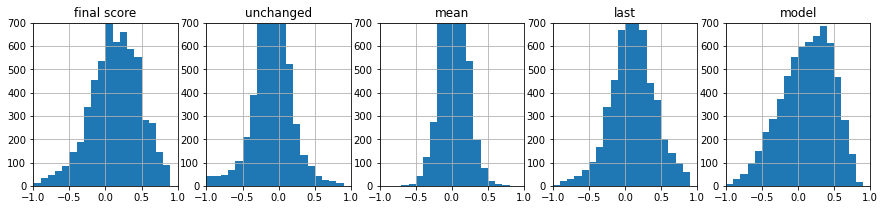

In [32]:
pred_column_names2 = ['final score']+pred_column_names
fig, axs = plt.subplots(1,len(pred_column_names2), figsize=(3*len(pred_column_names2),3))
for ax, column_name in zip(axs,pred_column_names2):
  ax = tmp_df[column_name].hist(ax=ax,bins=np.arange(-1.0,1.0,.1))
  ax.set_xlim(-1,1)
  ax.set_ylim(0,700)
  ax.set_title(column_name)

# **5**. Plotting the results

In [33]:
# remove "initial score" baseline
# from mpl_toolkits.axes_grid1 import make_axes_locatable # TODO: REMOVE ALL COMMENTED CODE?

# TODO: add doc to function
def plot_prediction_density(tmp_df, pred_column_names, subreddit=None, axs=None, choice_inds=None, cmap=plt.cm.gist_earth_r, vmax=None):
  if subreddit is not None:
    tmp_df = tmp_df.loc[subreddit2range[subreddit]]

  xmin = ymin = -1.
  xmax = ymax =  1.

  # deltaX = (max(x) - min(x))/10
  # deltaY = (max(y) - min(y))/10
  # xmin = min(x) - deltaX
  # xmax = max(x) + deltaX
  # ymin = min(y) - deltaY
  # ymax = max(y) + deltaY
  # xx, yy = np.mgrid[xmin:xmax:50j, ymin:ymax:50j]

  xx, yy = np.mgrid[xmin:xmax:50j, ymin:ymax:50j]
  positions = np.vstack([xx.ravel(), yy.ravel()])
  reset_seeds()

  if choice_inds is None:
    choice_inds = np.random.choice(len(tmp_df), 100)
  print(tmp_df.iloc[choice_inds]['thread ncom'].max())
  # choice_inds = np.random.choice(nz[0], 100)

  if axs is None:
   fig, axs = plt.subplots(2,2,figsize=(3*2,3*2),sharex=True,sharey=True)
   plt.subplots_adjust(wspace=.15,hspace=.15)

  for idx, (ax, column_name) in enumerate(zip(axs.ravel(),pred_column_names)):
    loss_array = tmp_df[['final score', column_name]].values
    kernel = stats.gaussian_kde(loss_array.T)
    Z = np.reshape(kernel(positions).T, xx.shape)
    # print(subreddit,idx,Z.min(),Z.max())

    if vmax is not None:
      levels = np.linspace(vmax/8.,vmax,8)
      # levels = np.insert(np.linspace(vmax*2/7.,vmax,7),0,0)
      vmin=vmax/8.
    else:
      levels = 8
      vmin=None

    ax.plot([xmin, xmax], [ymin, ymax], ls='-', c='k',alpha=.5)#,transform=ax.transAxes)

    # cfset = ax.contourf(xx, yy, Z, cmap=cmap, levels=levels)
    hb = ax.imshow(np.rot90(Z), cmap=cmap, aspect='auto',
              extent=[xmin, xmax, ymin, ymax], vmin=0,vmax=vmax)
    # cset = ax.contour(xx, yy, Z, colors='k', linewidths=.25, levels=levels)
    # plt.colorbar(hb, ax=ax)
    # ax.clabel(cset, inline=1, fontsize=8)


    ncom = tmp_df['branch ncom'].values if column_name.startswith('branch') else tmp_df['thread ncom'].values
    ax.scatter(loss_array[choice_inds,0], loss_array[choice_inds,1], 2*ncom[choice_inds], 'gray', edgecolor='k')

    ax.set_xlim([xmin, xmax])
    ax.set_ylim([ymin, ymax])
    # ax.yaxis.tick_right()
    # ax.set_xticks(np.arange(-1.,1.,.5))
    ax.set_yticks(np.arange(-1.,1.01,.5))
    ax.grid(ls='--', c='gray', alpha=.5)

    # ax.axhline((ymin+ymax)/2,color='k',alpha=.5)
    # ax.axvline((xmin+xmax)/2,color='k',alpha=.5)
    # x = np.array([xmin,xmax])
    # ax.plot(x, 1.5*x, ls='--', c='k',alpha=.5)
    # ax.plot(x, 0.5*x, ls='--', c='k',alpha=.5)
    # ax.set_title(column_name)


  # divider = make_axes_locatable(plt.gca())
  # cax = divider.append_axes("right", size="2%", pad=0.00)
  # cbar = fig.colorbar(hb, cax=cax)

  # fig.text(0.5, 0.04, r'EmT($c_n$) (true value)', ha='center')
  # fig.text(0.04, 0.5, 'prediction', va='center', rotation='vertical')

  # plt.savefig(RESULTSDIR+subreddit+'.pdf')
  return hb

34
64
46
58


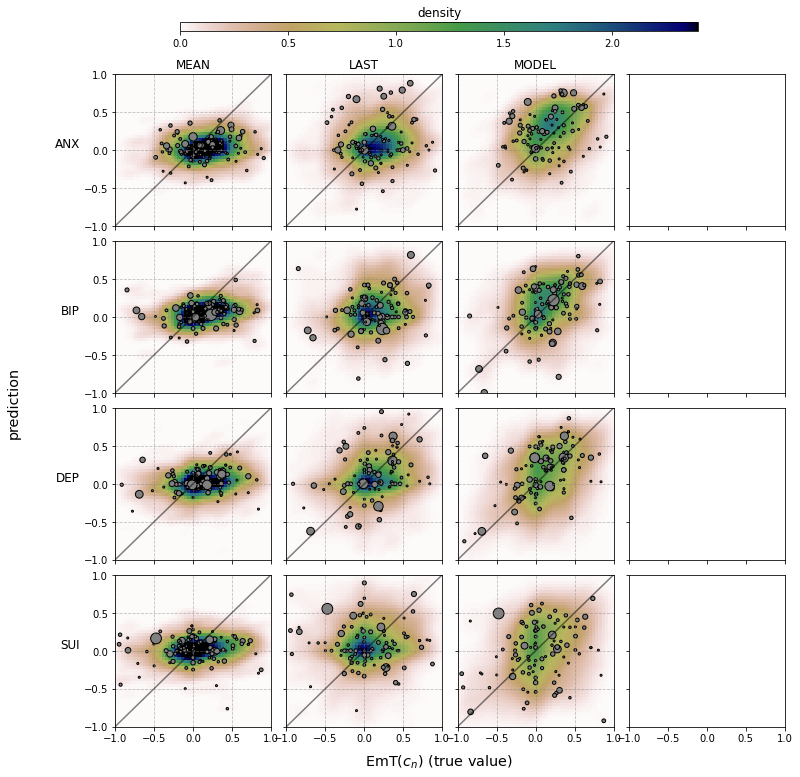

In [34]:
# plot density
vmax_list = [2, 3.2, 2., 2.]
vmax_list = [2.4, 2.4, 2.4, 2.4]

choice_inds = None

fig, axs = plt.subplots(4,4,figsize=(3*4,3*4),sharex=True,sharey=True)
plt.subplots_adjust(wspace=.1,hspace=.1)

for ix, subreddit in enumerate(SUBREDDITS):
  hb = plot_prediction_density(tmp_df, pred_column_names[1:], subreddit, axs[ix,:], choice_inds=choice_inds, vmax=vmax_list[ix])

fig.text(0.5 , 0.08, r'EmT($c_n$) (true value)', ha='center', fontsize='x-large')
fig.text(0.0, 0.5 , 'prediction', va='center', rotation='vertical', fontsize='x-large')

cbaxes = fig.add_axes([0.2, 0.93, .6, 0.01])

for ax, col in zip(axs[0], pred_column_names[1:]):
  ax.set_title(col.upper(), size='large')

for ax, row in zip(axs[:,0], SUBREDDITS):
  # ax.yaxis.set_label_position("right")
  ax.set_ylabel(subreddit2title[row.lower()], rotation=0, size='large', horizontalalignment='right')

cb = plt.colorbar(hb, cax = cbaxes, orientation='horizontal')
cb.ax.set_title('density', size='large')
plt.savefig('heatmaps.pdf')

# fig.colorbar(hb, ax=axs,location='bottom', shrink=.5)
# plt.tight_layout()

# divider = make_axes_locatable(plt.gca())
# cax = divider.append_axes("right", size="2%", pad=0.00)
# cbar = fig.colorbar(hb, cax=cax)


# **6**. Case Study

In [35]:
# TODO: explain what we are reading
REDDIT='SuicideWatch'
suffix = '.pkl'
with open(DATADIR+REDDIT+'_post2data'+suffix,'rb') as infile:
  post2data = pickle.load(infile)

with open(DATADIR+REDDIT+'_comment2data'+suffix,'rb') as infile:
  comment2data = pickle.load(infile)

In [36]:
# 58762
z = tmp_df.loc[subreddit2range2['SuicideWatch']]
z[(z['final score'] > 0.75) & (z['model'] < -0.75)].sort_values('final score',ascending=True).head(20)

,unchanged,final score,thread ncom,mean,last,model
58762,-0.8004,0.875,7,-0.252438,-0.1761,-0.924283


In [37]:
# 40001
z = tmp_df.loc[subreddit2range2['Anxiety']]
z[(z['final score'] > 0.75) & (z['model'] > 0.6)].sort_values('thread ncom',ascending=True).head(20)

,unchanged,final score,thread ncom,mean,last,model
4001,-0.064500,0.87575,2,0.019070,0.102640,0.738621
6195,-0.069314,0.84765,2,0.074051,0.217417,0.670077
11413,0.077006,0.86020,2,0.229403,0.381800,0.675297
6468,-0.881900,0.76500,3,-0.291783,-0.116650,0.881205
4296,0.238200,0.91360,4,0.132615,-0.050111,0.667778
6265,-0.189891,0.84810,4,-0.007503,0.075833,0.623252
1095,-0.081675,0.97360,6,0.301792,0.784500,0.759436
4046,0.080025,0.87200,8,0.133222,0.678867,0.771953
11193,0.067716,0.91180,10,0.356118,0.063900,0.685597
10024,-0.251600,0.90420,13,0.094388,0.119744,0.701931


In [41]:
def print_post_and_comments(index, suffix='', infile_extension='.pkl'):
  post = post_df.iloc[index]

  print(f'Post id: {post.name[1]}')
  print(f'Author (score {(post["score"][0]-0.5)*2}):')

  subreddit = post.name[0]
  with open(f'{DATADIR}{subreddit}_comment2data{suffix}{infile_extension}','rb') as infile:
    comment2data = pickle.load(infile)

  comment_ids = post.comments
  pprint.pprint(post.text)
  for cx in range(max(0,post.seq_len-10),post.seq_len-1):
    print('Author' if post.is_post_author[cx+1] else 'Commenter', end='')
    print(f' (score {(post["score"][cx+1])}):')
    if 'body' in comment2data[comment_ids[cx]]:
      pprint.pprint(comment2data[comment_ids[cx]]['body'])
    else:
      pprint.pprint(comment2data[comment_ids[cx]]['text'])

In [42]:
# TODO: remove for in all cells below, just set ind to each value
for ind in [58762]:
  print(post_df.iloc[ind])
  print(tmp_df.loc[ind])
  print_post_and_comments(ind)

features          [[tensor(0.0878), tensor(0.2793), tensor(0.061...
score             [-0.8004, -0.1909, 0.25, 0.07773333333333333, ...
is_post_author    [True, False, True, False, True, False, True, ...
seq_len                                                           8
Name: (SuicideWatch, 712ctw), dtype: object
unchanged     -0.800400
final score    0.875000
thread ncom    7.000000
mean          -0.252438
last          -0.176100
model         -0.924283
Name: 58762, dtype: float64
Post id: 712ctw
Author (score -2.6008):


AttributeError: 'Series' object has no attribute 'comments'

In [ ]:
%debug

> c:\users\fabri\.conda\envs\ds\lib\site-packages\pandas\core\generic.py(5139)__getattr__()
   5137             if self._info_axis._can_hold_identifiers_and_holds_name(name):
   5138                 return self[name]
-> 5139             return object.__getattribute__(self, name)
   5140 
   5141     def __setattr__(self, name: str, value) -> None:

ipdb> up
> <ipython-input-41-50c1b3ab6bc5>(11)print_post_and_comments()
      9     comment2data = pickle.load(infile)
     10 
---> 11   comment_ids = post.comments
     12   pprint.pprint(post.text)
     13   for cx in range(max(0,post.seq_len-10),post.seq_len-1):

ipdb> post.columns
*** AttributeError: 'Series' object has no attribute 'columns'
ipdb> post
features          [[tensor(0.0878), tensor(0.2793), tensor(0.061...
score             [-0.8004, -0.1909, 0.25, 0.07773333333333333, ...
is_post_author    [True, False, True, False, True, False, True, ...
seq_len                                                           8
Name: (SuicideWa

In [ ]:
# 13443
z = tmp_df.loc[subreddit2range2['bipolar']]
z[(z['final score'] < -0.75) & (z['model'] < 0.1) & (z['model'] > 0)].sort_values('thread ncom',ascending=False).head(20)

In [ ]:
# 14183
z[(z['final score'] > -0.5) & (z['model'] < -0.5)].sort_values('thread ncom',ascending=False).head(20)

In [ ]:
# 50549
z = tmp_df.loc[subreddit2range2['SuicideWatch']]
z[(z['final score'] > .6) & (z['final score'] < .75)  & (z['model'] > .6) & (z['model'] < .75)].sort_values('thread ncom',ascending=False)


In [ ]:
for ind in [50549]:
  print(post_df.iloc[ind])
  print(tmp_df.loc[ind])
  print_post_and_comments(ind)

In [ ]:
for ind in [13443]:
  print(post_df.iloc[ind])
  print(tmp_df.loc[ind])
  print_post_and_comments(ind)
  print('------------------------------------------------------')

In [ ]:
# loader  = DataLoader(Subset(dataset, [4834,4835]), batch_size=2, shuffle=False, num_workers=1)
# test_loss, outputs = evaluate(model, iter(loader), criterion=criterion, device=device, return_predictions=True)
# model_yhat = outputs[0][0].cpu().numpy() # extract data from outputs
# ilocs = outputs[0][2].cpu().numpy()
# model_series = pd.Series(model_yhat.ravel(),index=ilocs)
# model_series

In [ ]:
# print sample results
tmp_df.loc[47832].drop(columns=['thread ncom'])

In [ ]:
# (depression, 7im4c6)
post_df.iloc[47832]
tmp_df.loc[47832]
#print_post_and_comments(47832)

In [ ]:
# (bipolar, 5ukczo)
print(post_df.iloc[13149])
tmp_df.loc[13149]
#print_post_and_comments(13149)

In [ ]:
post_df.index.get_loc(('depression', '7im4c6'))

In [ ]:
print_post_and_comments(4834)

# **7**. Can we predict large fluctuations from one author comment to the next?

1. Plot the distribution of changes from one comment to the next.
2. Take the largest fluctuations and see how well we predict those. Is this large or small? Are the baselines predicting those better?
3. For those that we do well, inspect content of the post, "last checkpoint of author", following comment and last comment of author.

In [ ]:
#TODO: alternate the cells with the descriptions 1,2,3 above
fluctuations = []


for batch in test_loader:
  is_author_value = batch[0][0][0,-1] # this has to be retrieved because the feature was z-normalized
  batch_size = batch[0].size(0)

for ix in range(batch_size):
    ncom = batch[1][ix]
    for jx in range(ncom-1,-1,-1):
      if batch[0][ix][jx,-1] == is_author_value:
          fluctuations.append(batch[2][ix]-(batch[0][ix][jx,-2]*score_s+score_m))
          break   

fluctuations = np.array(fluctuations)
# fluctuation_series = pd.Series(fluctuations, index=test_locs)
fluctuation_series = pd.Series(fluctuations)
fluctuation_series.hist()

In [ ]:
fluctuation_series = tmp_df['final score']-tmp_df['unchanged']
fluctuation_series.head()

In [ ]:
# positive variation



def get_error_stats(series, lower_bound=None,upper_bound=None):
  assert (lower_bound is not None) ^ (upper_bound is not None)
  if upper_bound is not None:
    selected_inds = series[series < upper_bound].index
    print(f'[Upper bound: {upper_bound:.3f}] ',sep='')
  if lower_bound is not None:
    selected_inds = series[series > lower_bound].index
    print(f'[Lower bound: {lower_bound:.3f}] ',sep='')

  sub_df = tmp_df.loc[selected_inds]

  model_error = (sub_df['final score']-sub_df['model']).abs()
  results = {'MODEL L1':model_error.mean()}
  for baseline in ['mean','last','xgb']:
    baseline_error = (sub_df['final score']-sub_df[baseline]).abs()
    succ_fraction = (model_error < baseline_error).mean()
    print( f"Model outperforms {baseline} in {succ_fraction*100:.1f}% of all cases")
    print( f"Model error: {model_error.mean():.3f}\t Baseline error: {baseline_error.mean():.3f}")
    results[baseline] = {f'M outp. {baseline.upper()} (%)': succ_fraction,
                         f'{baseline.upper()} L1': baseline_error.mean() }

  print(f"Cases: {len(selected_inds)}\n\n")
  return results

n=len(fluctuation_series)
upper_bound=fluctuation_series.sort_values().iloc[int(0.05*n)]
lower_bound=fluctuation_series.sort_values().iloc[int(0.95*n)]

extreme_stats = {}

print('XXXX Fluctuation from previous comment: <5-th and >95-th percentile')
extreme_stats['EmT shift $>$ 95th perc.'] = get_error_stats(fluctuation_series, lower_bound=lower_bound)
extreme_stats['EmT shift $>$ +1.0'] = get_error_stats(fluctuation_series, lower_bound=1.)
extreme_stats['Final EmT $>$ +0.8'] = get_error_stats(tmp_df['final score'], lower_bound=.8)

extreme_stats['EmT shift $<$  5th perc.'] = get_error_stats(fluctuation_series, upper_bound=upper_bound)
extreme_stats['EmT shift $<$ -1.0'] = get_error_stats(fluctuation_series, upper_bound=-1.)
extreme_stats['Final EmT $<$ -0.8'] = get_error_stats(tmp_df['final score'], upper_bound=-.8)

print('XXX Fluctuation from previous comment: <-0.5 and >0.5')

print('XXX Final score: <0.1 and >0.9')


In [ ]:
extreme_df = pd.DataFrame.from_dict(extreme_stats, orient='index')
extreme_df = pd.concat((extreme_df,extreme_df['mean'].apply(pd.Series),extreme_df['last'].apply(pd.Series),extreme_df['xgb'].apply(pd.Series)), axis=1).drop(columns=['last','mean','xgb'])
#extreme_df[['MEAN L1','MODEL L1','LAST L1','XGB L1']] = extreme_df[['MEAN L1','MODEL L1','LAST L1']].multiply(2)
extreme_df = extreme_df.round(3)
extreme_df['M outp. MEAN (%)'] = extreme_df['M outp. MEAN (%)']*100
extreme_df['M outp. LAST (%)'] = extreme_df['M outp. LAST (%)']*100
extreme_df['M outp. XGB (%)'] = extreme_df['M outp. XGB (%)']*100

new_columns = [extreme_df.columns[ix] for ix in [0,2,4,6,1,3,5]] 
extreme_df = extreme_df[new_columns]
extreme_df

In [ ]:
formatters = []
for ix, column in enumerate(extreme_df.columns):
  formatters.append(lambda x, column_ix=ix: '\\textbf{%s}'%( ('%.1f' % float(x)).lstrip('0') ) if (column_ix >=3 and x > 50) else ('%.3f'% float(x)).lstrip('0') )
formatters

In [ ]:
print(extreme_df.to_latex(
    column_format='l|rrrr|ccc',  escape=False, label='tab:extreme_values', formatters=formatters,
    caption='Performance on extreme values. Central columns show L1 error for \\textsc{Mean}, \\textsc{Model} and \\textsc{Last}. '+
    'First (last) column show fraction of cases (selected from test set according to row description) where \\textsc{Model} outperforms '+
    '\\textsc{Mean} (\\textsc{Last}). For extremely positive shifts, \\textsc{Last} performs best because a large improvement is often '+
    'preceded by a very positive comment. For extremely negative shifts, \\textsc{Model} performs best.'))

In [ ]:
for ind in large_change_inds:
  print(ind, branch_data[ind])
  index, _, bx = branch_data[ind]
  b = post_df.loc[index].valid_branches[bx]
  print(index, bx, b)
  print(post_df.loc[index].features[b,-2])
  print(post_df.loc[index].features[b,-1])


In [ ]:
for pred_column_name in pred_column_names:
  test_loss[pred_column_name] = compute_error(tmp_df.iloc[large_change_inds], pred_column_name, criteria)
pd.DataFrame.from_dict(test_loss, orient='index').round(3)

In [ ]:
attn_weights = attn_weights.squeeze(1).cpu().numpy()

In [ ]:
count_nz = np.count_nonzero( attn_weights,  axis=1)

In [ ]:
attn_weights_sorted = -np.sort(-attn_weights, axis=1)
imbalance = (attn_weights_sorted[:,0]-attn_weights_sorted[:,1])
imbalance_index = np.argsort(-imbalance)
imbalance_index[0]

In [ ]:
X = np.vstack((pred_error,imbalance,initial_scores,y,yhat,te_diff, count_nz))
X = X.T
tmp_df = pd.DataFrame(X, columns=['pred_error','imbalance','initial_score','final_score','prediction','te_diff', 'count_nz'], index=post_ids)
tmp_df.tail()

In [ ]:
pred_error = np.absolute(z[:,0]-z[:,1])
cost = pred_error-2*imbalance.cpu().numpy()-0.6*np.absolute(z[:,1])-0.1*(attn_weights[:,0,2].cpu().numpy()>0)
index_array = np.argsort(cost)
index_array[:10]

In [ ]:
index = index_array[2]
print(z[index])
attn_weights[index]

In [ ]:
post_id = post_ids[index]
post=post_df.loc[post_id]
print(post)
#pprint.pprint(post['text'])

In [ ]:
comment = comment_df.loc[post_df.loc[post_id,'comments'][7]]
print(comment) 
pprint.pprint(comment['text'])